# Neural Radiance Fields

This notebook was written while referencing the original NeRF code so as to visualize step by step on how NeRF works. Some functions have been refactored for better understanding but as much as possible, none of the actual code was changed.

## Attribution and Citation
- Original paper: Mildenhall, Ben; Srinivasan, Pratul P.; Tancik, Matthew; Barron, Jonathan T.; Ramamoorthi, Ravi; Ng, Ren. “NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis.” ECCV 2020. [arXiv:2003.08934](https://arxiv.org/abs/2003.08934)
- Reference code: [bmild/nerf](https://github.com/bmild/nerf) (MIT License). Copyright © 2020 Ben Mildenhall.

```bibtex
@inproceedings{mildenhall2020nerf,
  title     = {NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis},
  author    = {Mildenhall, Ben and Srinivasan, Pratul P. and Tancik, Matthew and Barron, Jonathan T. and Ramamoorthi, Ravi and Ng, Ren},
  booktitle = {European Conference on Computer Vision (ECCV)},
  year      = {2020}
}
```

## Import Dependencies and Check CUDA

In [1]:
# Standard libraries
import sys
import os
import time

# Third party libraries
import imageio
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, trange

import matplotlib.pyplot as plt

# Helper libraries
from embedder import *
from nerf_helpers import *
import utils

# Loaders
from load_llff import *
from load_blender import *
from load_deepvoxels import * 
from load_LINEMOD import *

# Set seed
np.random.seed(0)
DEBUG = False
torch.set_default_dtype(torch.float32)

In [2]:
# Check device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load experiment config from yaml
EXPERIMENT_NAME = "chair_blender500k"
folder_path = os.path.join("yaml", EXPERIMENT_NAME)
print(f"Targeted yaml folder: {folder_path}")

# Load the yaml data for use later in terms of args.
args = utils.load_or_create_config(folder_path)

print(f"Experiment name: {args["expname"]}")

Targeted yaml folder: yaml\chair_blender500k
Loading configuration from yaml\chair_blender500k
Configuration validation passed! Arguments are valid and correctly set.
Experiment name: chair_blender500k


In [4]:
# Convert dict-style args to dot-access with recursive wrapping
class AttrDict(dict):
    """Dictionary with attribute-style access that recursively wraps nested dicts/lists.

    Example:
        d = AttrDict.from_obj({"a": {"b": 1}, "c": [{"d": 2}]})
        d.a.b == 1
        d.c[0].d == 2
        d.new_key = 3  # also writes to the underlying dict
    """
    __slots__ = ()

    def __getattr__(self, name):
        try:
            return self[name]
        except KeyError as e:
            raise AttributeError(f"No such attribute: {name}") from e

    def __setattr__(self, name, value):
        self[name] = value

    @classmethod
    def from_obj(cls, obj):
        if isinstance(obj, dict):
            return cls({k: cls.from_obj(v) for k, v in obj.items()})
        if isinstance(obj, list):
            return [cls.from_obj(v) for v in obj]
        return obj

# If args came from YAML as a plain dict, wrap it for dot access
try:
    if isinstance(args, dict):
        args = AttrDict.from_obj(args)
        print("Converted args dict to AttrDict (dot-access enabled). Example: args.expname ->", args.expname)
except NameError:
    # If this cell runs before args is defined, it's a no-op
    pass


Converted args dict to AttrDict (dot-access enabled). Example: args.expname -> chair_blender500k


## Render

NeRF rendering utilities

This part contains helper functions to render volumes using Neural Radiance Fields (NeRF).
If you're new to NeRF, here's the high-level idea you'll see reflected in the code:

- A NeRF model takes a 3D point (and often a viewing direction) and predicts color (RGB)
  and density (sigma) at that point.
- To render an image, we cast a ray through each pixel, sample many points along the ray,
  evaluate the network at those points, and composite the colors using volume rendering.
- We optionally do this in two passes: a coarse pass to find where the scene is, then a
  fine pass that samples more densely in the important regions (importance sampling).

The functions below help with:
- Splitting big tensors/ray sets into smaller chunks to avoid out-of-memory issues.
- Converting raw network outputs into rendered RGB/depth/opacity via volume rendering.
- Orchestrating the full per-ray rendering with optional hierarchical sampling.


In [5]:
"""
The following function wraps a function fn so it processes a large input tensor in smaller chunks
to reduce peak memory usage, then stitches the result together.

This splits inputs along the first dimension into slices of size chunk and applies fn to each slice.
Then it concatenates the results back together along the first dimension.

This reduces gpu and cpu spikes when fn is heavy (i.e neural network forward pass) and preserves
autograd, as gradients flow through torch.cat and slicing.
"""
def batchify(fn, chunk):
    """Wrap a function so it runs on smaller input chunks to reduce peak memory.

    This is useful for heavy functions like neural network forward passes. Instead of
    evaluating the entire input tensor in one go, we split it along the first dimension
    into slices of size ``chunk`` and then concatenate the results.

    Args:
        fn (Callable[[Tensor], Tensor]): The function to run on chunks.
        chunk (Optional[int]): Number of rows to process per call. If ``None``,
            no chunking is performed.

    Returns:
        Callable[[Tensor], Tensor]: A wrapper that applies ``fn`` on input chunks and
        stitches the outputs along the first dimension.
    """
    if chunk is None:
        return fn
    def ret(inputs):
        return torch.cat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    return ret


In [6]:
def raw2outputs(raw, z_vals, rays_d, raw_noise_std=0, white_bkgd=False, pytest=False):
    """
    Convert raw network predictions along rays into rendered outputs using
    volumetric rendering (accumulation over samples).

    High-level intuition (NeRF volume rendering):
    - The network predicts, per sampled point along a ray, an RGB value and a density
      (often called sigma). Density indicates how much light is absorbed/emitted there.
    - We turn densities into per-sample opacities (alpha) based on the distance between
      adjacent samples along the ray.
    - We compute transmittance (how much light makes it to a sample without being blocked)
      via a cumulative product, then form per-sample weights = transmittance * alpha.
    - We composite colors, depths, and other quantities by weighted sums over samples.

    Args:
        raw (torch.Tensor): [N_rays, N_samples, 4] raw predictions per sample. The first
            3 channels are RGB logits (before sigmoid), and the last channel is density (sigma).
        z_vals (torch.Tensor): [N_rays, N_samples] sample depths or t-values along each ray.
        rays_d (torch.Tensor): [N_rays, 3] direction vectors for each ray. Used to scale
            step sizes from parametric units to metric distances.
        raw_noise_std (float): Stddev of Gaussian noise added to sigma during training for
            regularization. Set to 0.0 at eval time.
        white_bkgd (bool): If True, composite the result over a white background (useful
            for synthetic datasets rendered on white).
        pytest (bool): If True, use deterministic numpy noise for reproducible tests.

    Returns:
        tuple:
            - rgb_map (torch.Tensor): [N_rays, 3] rendered RGB color per ray.
            - disp_map (torch.Tensor): [N_rays] disparity (inverse depth) per ray.
            - acc_map (torch.Tensor): [N_rays] accumulated opacity per ray (sum of weights).
            - weights (torch.Tensor): [N_rays, N_samples] per-sample contribution weights.
            - depth_map (torch.Tensor): [N_rays] expected depth per ray.
    """
    # Map density (sigma) and step size (distance between samples) to opacity (alpha):
    #   alpha = 1 - exp(-relu(sigma) * delta)
    # relu ensures sigma is non-negative, as negative density is not physical.
    raw2alpha = lambda raw_sigma, dists, act_fn=F.relu: 1.0 - torch.exp(-act_fn(raw_sigma) * dists)

    # Compute distances between adjacent samples along each ray in z (or t) space.
    # Shape after diff: [N_rays, N_samples-1]
    dists = z_vals[..., 1:] - z_vals[..., :-1]

    # For the last sample on each ray, append a very large distance so that its
    # contribution is properly modeled as the ray exiting the volume.
    # Resulting shape: [N_rays, N_samples]
    dists = torch.cat([dists, torch.tensor([1e10], device=z_vals.device, dtype=z_vals.dtype).expand(dists[..., :1].shape)], dim=-1)

    # Convert parametric distances to metric distances by multiplying by the ray length.
    # This accounts for non-unit ray directions. rays_d[..., None, :] has shape [N_rays, 1, 3]
    # and we take its L2 norm to scale each sample distance.
    dists = dists * torch.norm(rays_d[..., None, :], dim=-1)

    # Convert raw RGB logits to [0,1] colors per sample.
    rgb = torch.sigmoid(raw[..., :3])  # [N_rays, N_samples, 3]

    # Optional noise added to densities during training for regularization.
    # Ensure raw_noise_std is a float (configs may pass strings).
    try:
        noise_std = float(raw_noise_std)
    except (TypeError, ValueError):
        noise_std = 0.0

    noise = 0.0
    if noise_std > 0.0:
        noise = torch.randn(raw[..., 3].shape, device=raw.device, dtype=raw.dtype) * noise_std

        # Deterministic noise path for unit tests.
        if pytest:
            np.random.seed(0)
            noise_np = np.random.rand(*list(raw[..., 3].shape)) * noise_std
            noise = torch.tensor(noise_np, device=raw.device, dtype=raw.dtype)

    # Opacity per sample from density and distance.
    alpha = raw2alpha(raw[..., 3] + noise, dists)  # [N_rays, N_samples]
    weights = alpha * torch.cumprod(torch.cat([torch.ones((alpha.shape[0], 1), device=alpha.device, dtype=alpha.dtype), 1.-alpha + 1e-10], -1), -1)[:, :-1]

    # Rendered color is the weighted sum of per-sample colors along the ray.
    rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)  # [N_rays, 3]

    # Expected depth is the weighted sum of sample depths.
    depth_map = torch.sum(weights * z_vals, dim=-1)

    # Disparity is inverse depth. We divide expected depth by total weight (visibility)
    # and guard with epsilon to avoid divide-by-zero when the ray hits nothing.
    denom = torch.max(1e-10 * torch.ones_like(depth_map), torch.sum(weights, dim=-1))
    disp_map = 1.0 / torch.clamp(depth_map / denom, min=1e-10)

    # Accumulated opacity along the ray (how much of the ray got "stopped").
    acc_map = torch.sum(weights, dim=-1)

    # If the scene assumes a white background, composite the missing transmittance as white.
    if white_bkgd:
        rgb_map = rgb_map + (1.0 - acc_map[..., None])

    return rgb_map, disp_map, acc_map, weights, depth_map

In [7]:
def render_rays(ray_batch,
                network_fn,
                network_query_fn,
                N_samples,
                retraw=False,
                lindisp=False,
                perturb=0.,
                N_importance=0,
                network_fine=None,
                white_bkgd=False,
                raw_noise_std=0.,
                verbose=False,
                pytest=False):
    """Render a bundle of rays using NeRF-style volume rendering.

    High-level steps for each ray:
    1) Sample N points between near and far along the ray (evenly in depth or inverse depth).
    2) Query the network at those 3D points (and optionally view directions) to get raw RGB+sigma.
    3) Convert raw predictions to colors via volume rendering (accumulate with alphas/weights).
    4) If enabled, run hierarchical (importance) sampling: take a second set of samples drawn
       from a PDF defined by the coarse weights, re-evaluate the network (fine), and re-render.

    Args:
        ray_batch (torch.Tensor): [num_rays, Cray]. Per-ray data packed together. The first
            3 entries are ray origins, next 3 are ray directions, next 2 are near/far bounds,
            and the last 3 (if present) are unit view directions for view-dependent effects.
        network_fn (Callable): The coarse NeRF MLP. Given points (and viewdirs), predicts
            raw RGB (logits) and density (sigma).
        network_query_fn (Callable): A helper that formats inputs and calls the network.
        N_samples (int): Number of stratified samples for the coarse pass.
        retraw (bool): If True, also return the raw outputs from the last pass.
        lindisp (bool): If True, sample uniformly in inverse depth (disparity) instead of depth.
            This concentrates samples near the camera, helpful for scenes with large depth ranges.
        perturb (float): If > 0, enable stratified sampling noise during training for anti-aliasing.
        N_importance (int): Extra samples for the fine pass (hierarchical sampling). 0 disables it.
        network_fine (Optional[Callable]): A separate fine MLP. If None, reuse ``network_fn``.
        white_bkgd (bool): If True, composite the result over a white background.
        raw_noise_std (float): Stddev of Gaussian noise added to density during training.
        verbose (bool): If True, print additional debug information.
        pytest (bool): If True, make randomness deterministic for unit tests.

    Returns:
        Dict[str, torch.Tensor]: Always includes:
            - ``rgb_map`` [num_rays, 3]: Rendered color from the last pass (fine if enabled).
            - ``disp_map`` [num_rays]: Disparity (1/depth) from the last pass.
            - ``acc_map`` [num_rays]: Accumulated opacity from the last pass.
        Optionally includes:
            - ``raw`` [num_rays, num_samples, 4]: Raw outputs of the last pass if ``retraw``.
            - ``rgb0``, ``disp0``, ``acc0``: Coarse pass results when ``N_importance > 0``.
            - ``z_std`` [num_rays]: Std. dev. of fine samples (measures sampling concentration).
    """
    N_rays = ray_batch.shape[0]
    # Unpack packed ray data: origins, directions, near/far bounds, and optional viewdirs.
    rays_o, rays_d = ray_batch[:,0:3], ray_batch[:,3:6] # [N_rays, 3] each
    viewdirs = ray_batch[:,-3:] if ray_batch.shape[-1] > 8 else None
    bounds = torch.reshape(ray_batch[...,6:8], [-1,1,2])
    near, far = bounds[...,0], bounds[...,1] # [-1,1]

    # Step 1: Choose parametric sample positions t in [0, 1] and map to depths z in [near, far].
    t_vals = torch.linspace(0., 1., steps=N_samples, device=ray_batch.device)
    if not lindisp:
        # Uniform samples in depth
        z_vals = near * (1.-t_vals) + far * (t_vals)
    else:
        # Uniform samples in inverse depth (places more samples closer to the camera)
        z_vals = 1./(1./near * (1.-t_vals) + 1./far * (t_vals))

    z_vals = z_vals.expand([N_rays, N_samples])

    if perturb > 0.:
        # During training, jitter samples within each interval for stratified sampling.
        # This reduces aliasing and improves robustness.
        # Get intervals between samples
        mids = .5 * (z_vals[...,1:] + z_vals[...,:-1])
        upper = torch.cat([mids, z_vals[...,-1:]], -1)
        lower = torch.cat([z_vals[...,:1], mids], -1)
        # Draw stratified samples inside those intervals
        t_rand = torch.rand(z_vals.shape, device=z_vals.device)

        # Pytest, overwrite u with numpy's fixed random numbers
        if pytest:
            np.random.seed(0)
            t_rand = np.random.rand(*list(z_vals.shape))
            t_rand = torch.tensor(t_rand, device=z_vals.device, dtype=z_vals.dtype)

        z_vals = lower + (upper - lower) * t_rand

    # Compute 3D sample locations along each ray: o + t*d for each sampled depth t (z_vals).
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None] # [N_rays, N_samples, 3]

    # raw = run_network(pts)
    # Query the (coarse) network at all sample points. ``viewdirs`` enables view-dependent effects.
    raw = network_query_fn(pts, viewdirs, network_fn)
    rgb_map, disp_map, acc_map, weights, depth_map = raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest=pytest)

    if N_importance > 0:

        rgb_map_0, disp_map_0, acc_map_0 = rgb_map, disp_map, acc_map

        # Hierarchical sampling (importance sampling):
        # Build a PDF from coarse weights and draw additional samples where the scene is likely.
        z_vals_mid = .5 * (z_vals[...,1:] + z_vals[...,:-1])
        # Exclude the first and last weights to avoid boundary artifacts when forming the PDF.
        z_samples = sample_pdf(z_vals_mid, weights[...,1:-1], N_importance, det=(perturb==0.), pytest=pytest)
        # Detach so gradients do not flow through the sampling operation.
        z_samples = z_samples.detach()

        # Merge coarse and fine samples, then sort along the ray.
        z_vals, _ = torch.sort(torch.cat([z_vals, z_samples], -1), -1)
        pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None] # [N_rays, N_samples + N_importance, 3]

        # Use dedicated fine network if provided, else reuse the coarse network.
        run_fn = network_fn if network_fine is None else network_fine
        # raw = run_network(pts, fn=run_fn)
        raw = network_query_fn(pts, viewdirs, run_fn)

        rgb_map, disp_map, acc_map, weights, depth_map = raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest=pytest)

    ret = {'rgb_map' : rgb_map, 'disp_map' : disp_map, 'acc_map' : acc_map}
    if retraw:
        ret['raw'] = raw
    if N_importance > 0:
        # Include coarse pass results for potential losses or visualization.
        ret['rgb0'] = rgb_map_0
        ret['disp0'] = disp_map_0
        ret['acc0'] = acc_map_0
        # Standard deviation of fine samples: indicates how concentrated sampling is per ray.
        ret['z_std'] = torch.std(z_samples, dim=-1, unbiased=False)  # [N_rays]

    for k in ret:
        if (torch.isnan(ret[k]).any() or torch.isinf(ret[k]).any()) and DEBUG:
            print(f"! [Numerical Error] {k} contains nan or inf.")

    return ret

In [8]:
"""
Render a large set of rays by splitting them into manageable minibatches to avoid
out-of-memory (OOM) issues, then stitch the per-batch results back together.

High-level intuition:
- Rendering involves evaluating many rays (often millions). Each ray requires sampling
  points, running an MLP, and compositing colors/densities, which can be memory-heavy.
- Instead of rendering all rays at once, we process them in chunks (minibatches), which
  keeps peak memory usage bounded.
- We collect and concatenate the results for each output quantity (e.g., rgb, depth, acc).
"""

def batchify_rays(rays_flat, chunk=1024*32, **kwargs):
    """
    Render rays in smaller minibatches to avoid OOM.

    Args:
        rays_flat (torch.Tensor): Rays flattened along the batch dimension, shape [N, Cray].
            Each row encodes a single ray's data (e.g., origin, direction, near/far, etc.).
        chunk (int): Number of rays to render per minibatch.
        **kwargs: Additional keyword arguments forwarded to `render_rays` (e.g., models,
            sampling counts, noise parameters).

    Returns:
        Dict[str, torch.Tensor]: A dictionary where each key corresponds to a rendered
        quantity (e.g., 'rgb_map', 'disp_map', 'acc_map', etc.), and each tensor has
        shape [N, ...], formed by concatenating per-chunk outputs along the first dimension.
    """
    # Accumulate lists of per-chunk outputs in a dictionary keyed by output name.
    all_ret = {}

    # Iterate over rays in chunks: [0:chunk], [chunk:2*chunk], ...
    for i in range(0, rays_flat.shape[0], chunk):
        # Render a minibatch of rays using the provided rendering function and settings.
        ret = render_rays(rays_flat[i:i+chunk], **kwargs)

        # For each output field produced by the renderer, append the minibatch result
        # to a growing list so we can concatenate later.
        for k in ret:
            if k not in all_ret:
                all_ret[k] = []
            all_ret[k].append(ret[k])

    # Concatenate lists of chunk results into full [N, ...] tensors for each field.
    all_ret = {k: torch.cat(all_ret[k], dim=0) for k in all_ret}

    return all_ret

In [9]:
def render(H, W, K, chunk=1024*32, rays=None, c2w=None, ndc=True,
                  near=0., far=1.,
                  use_viewdirs=False, c2w_staticcam=None,
                  **kwargs):
    """Render a full image or a provided set of rays using NeRF.

    There are two common ways to call this function:
    - Full image: pass a camera-to-world matrix ``c2w`` and camera intrinsics ``K``.
      The function will generate one ray per pixel and render all of them.
    - Custom rays: pass ``rays=(rays_o, rays_d)`` to render only those rays.

    Args:
        H (int): Image height in pixels.
        W (int): Image width in pixels.
        K (torch.Tensor or np.ndarray): 3x3 camera intrinsics matrix. We use ``K[0,0]``
            (focal length in pixels) when converting to NDC for forward-facing scenes.
        chunk (int): Max number of rays to process per minibatch to control memory usage.
        rays (tuple[Tensor, Tensor], optional): Tuple ``(rays_o, rays_d)`` with shapes
            [..., 3] each, giving ray origins and directions. If provided, ``c2w`` is ignored.
        c2w (torch.Tensor or np.ndarray, optional): [3,4] camera-to-world matrix. If provided,
            rays for the full image are generated via ``get_rays``.
        ndc (bool): If True, convert rays to normalized device coordinates (recommended for
            forward-facing scenes as in the original NeRF paper).
        near (float): Near plane distance used to initialize per-ray near bounds.
        far (float): Far plane distance used to initialize per-ray far bounds.
        use_viewdirs (bool): If True, pass unit viewing directions to the network to enable
            view-dependent appearance (specularities).
        c2w_staticcam (torch.Tensor or np.ndarray, optional): If provided with ``use_viewdirs``
            enabled, generate rays from ``c2w_staticcam`` but keep view directions from ``c2w``.
            This is useful to visualize how view-dependent effects change with direction.
        **kwargs: Forwarded to ``render_rays`` (e.g., networks, sample counts, noise settings).

    Returns:
        list: ``[rgb_map, disp_map, acc_map, extras]``
            - rgb_map: [H, W, 3] rendered colors
            - disp_map: [H, W] disparity (1/depth)
            - acc_map: [H, W] accumulated opacity
            - extras: dict with any additional outputs from ``render_rays``
    """
    # Infer rendering device from the model to keep all tensors consistent
    model_device = next(kwargs['network_fn'].parameters()).device

    if c2w is not None:
        # Special case: render a full image by generating one ray per pixel.
        rays_o, rays_d = get_rays(H, W, K, c2w)
    else:
        # Use the provided custom ray batch.
        rays_o, rays_d = rays

    if use_viewdirs:
        # Provide normalized ray directions to the network for view-dependent effects.
        viewdirs = rays_d
        if c2w_staticcam is not None:
            # Visualize only the effect of changing view direction while keeping camera fixed.
            rays_o, rays_d = get_rays(H, W, K, c2w_staticcam)
        viewdirs = viewdirs / torch.norm(viewdirs, dim=-1, keepdim=True)
        viewdirs = torch.reshape(viewdirs, [-1,3]).float().to(model_device)

    sh = rays_d.shape # [..., 3]
    if ndc:
        # Convert to NDC (assumes a pinhole camera model), commonly used for LLFF/forward-facing scenes.
        rays_o, rays_d = ndc_rays(H, W, K[0][0], 1., rays_o, rays_d)

    # Create ray batch
    rays_o = torch.reshape(rays_o, [-1,3]).float().to(model_device)
    rays_d = torch.reshape(rays_d, [-1,3]).float().to(model_device)

    # Initialize per-ray near/far bounds and pack rays into a single tensor expected by render_rays.
    near, far = near * torch.ones_like(rays_d[...,:1]), far * torch.ones_like(rays_d[...,:1])
    rays = torch.cat([rays_o, rays_d, near, far], -1)
    if use_viewdirs:
        rays = torch.cat([rays, viewdirs], -1)

    # Render all rays in memory-friendly chunks, then reshape results back to image grids.
    all_ret = batchify_rays(rays, chunk, **kwargs)
    for k in all_ret:
        k_sh = list(sh[:-1]) + list(all_ret[k].shape[1:])
        all_ret[k] = torch.reshape(all_ret[k], k_sh)

    k_extract = ['rgb_map', 'disp_map', 'acc_map']
    ret_list = [all_ret[k] for k in k_extract]
    ret_dict = {k : all_ret[k] for k in all_ret if k not in k_extract}
    return ret_list + [ret_dict]


In [10]:
def render_path(render_poses, hwf, K, chunk, render_kwargs, gt_imgs=None, savedir=None, render_factor=0, 
                calculate_metrics=False, metrics_include_lpips=True, metrics_device='cuda'):
    """Render a sequence of camera poses to produce a video or trajectory.

    This convenience function loops over a list/array of camera-to-world matrices and calls
    ``render`` for each pose. Optionally writes frames to ``savedir`` and/or renders at a
    lower resolution for speed.

    Args:
        render_poses (Iterable[Tensor or np.ndarray]): Sequence of [3,4] camera-to-world matrices.
        hwf (tuple): ``(H, W, focal)`` from dataset metadata. Only ``H`` and ``W`` are used here.
        K (Tensor or np.ndarray): 3x3 intrinsics matrix passed through to ``render``.
        chunk (int): Chunk size forwarded to ``render``.
        render_kwargs (dict): Keyword args forwarded to ``render`` (e.g., networks and settings).
        gt_imgs (optional): Ground-truth images; if provided, you can compute metrics.
        savedir (str, optional): If provided, write each rendered RGB frame as a PNG to this folder.
        render_factor (int): If > 0, downsample H and W by this factor to render faster.
        calculate_metrics (bool): If True and gt_imgs is provided, calculate image quality metrics.
        metrics_include_lpips (bool): Whether to include LPIPS in metrics calculation.
        metrics_device (str): Device to use for LPIPS calculation.

    Returns:
        If calculate_metrics=False: Tuple[np.ndarray, np.ndarray]: ``(rgbs, disps)``
        If calculate_metrics=True: Tuple[np.ndarray, np.ndarray, dict]: ``(rgbs, disps, metrics)``
        where metrics contains averaged PSNR, SSIM, and optionally LPIPS values.
    """

    H, W, focal = hwf

    if render_factor!=0:
        # Render downsampled for speed by reducing both resolution and focal length proportionally.
        H = H//render_factor
        W = W//render_factor
        focal = focal/render_factor

    rgbs = []
    disps = []
    
    # Initialize metrics collection if requested
    if calculate_metrics and gt_imgs is not None:
        from nerf_helpers import calculate_metrics as calc_metrics
        all_metrics = {'psnr': [], 'ssim': [], 'mse': []}
        if metrics_include_lpips:
            all_metrics['lpips'] = []

    t = time.time()
    for i, c2w in enumerate(tqdm(render_poses)):
        # Simple timing print to monitor rendering speed
        print(i, time.time() - t)
        t = time.time()

        # Render the current pose; we discard the accumulated opacity and extras here
        rgb, disp, acc, _ = render(H, W, K, chunk=chunk, c2w=c2w[:3,:4], **render_kwargs)
        rgbs.append(rgb.cpu().numpy())
        disps.append(disp.cpu().numpy())
        if i==0:
            print(rgb.shape, disp.shape)

        # Calculate metrics vs. ground truth if requested
        if calculate_metrics and gt_imgs is not None and render_factor==0 and i < len(gt_imgs):
            gt_img = gt_imgs[i]
            rendered_img = rgb.cpu().numpy()
            
            # Calculate comprehensive metrics
            metrics = calc_metrics(rendered_img, gt_img, 
                                 include_lpips=metrics_include_lpips, 
                                 device=metrics_device)
            
            # Store metrics
            for key in all_metrics:
                if key in metrics and metrics[key] is not None:
                    all_metrics[key].append(metrics[key])
            
            # Print metrics for this frame
            print(f"Frame {i} - PSNR: {metrics.get('psnr', 'N/A'):.2f}, "
                  f"SSIM: {metrics.get('ssim', 'N/A'):.4f}", end="")
            if metrics_include_lpips and 'lpips' in metrics:
                print(f", LPIPS: {metrics.get('lpips', 'N/A'):.4f}")
            else:
                print()

        # Optionally write the frame to disk as an 8-bit PNG.
        if savedir is not None:
            rgb8 = to8b(rgbs[-1])
            filename = os.path.join(savedir, '{:03d}.png'.format(i))
            imageio.imwrite(filename, rgb8)

    # Stack lists into contiguous arrays with a time dimension.
    rgbs = np.stack(rgbs, 0)
    disps = np.stack(disps, 0)

    # Calculate average metrics if requested
    if calculate_metrics and gt_imgs is not None:
        avg_metrics = {}
        for key, values in all_metrics.items():
            if values:  # Only average if we have values
                avg_metrics[f'avg_{key}'] = np.mean(values)
                avg_metrics[f'std_{key}'] = np.std(values)
        
        # Print summary
        print("\n=== METRICS SUMMARY ===")
        for key in ['psnr', 'ssim', 'lpips']:
            if f'avg_{key}' in avg_metrics:
                print(f"Average {key.upper()}: {avg_metrics[f'avg_{key}']:.4f} ± {avg_metrics[f'std_{key}']:.4f}")
        print("=======================")
        
        return rgbs, disps, avg_metrics

    return rgbs, disps


In [11]:
"""
Prepare 3D sample points for a NeRF-style network by applying positional encodings,
run the network on these encodings in memory-safe chunks, and then reshape the results
back to the original sampling layout.

High-level intuition:
- We often sample many 3D points (xyz) per ray and, optionally, use a per-ray viewing
  direction. Raw coordinates are hard for small MLPs to learn high-frequency detail,
  so we first apply a positional encoding that maps them to a higher-dimensional space.
- We flatten everything to a big batch so the network can process all samples uniformly.
- To avoid running out of memory, we split this big batch into chunks and process them
  sequentially, then stitch the outputs back together and restore the original shape.
"""

def run_network(inputs, viewdirs, fn, embed_fn, embeddirs_fn, netchunk=1024*64):
    """
    Prepare inputs for a NeRF-style MLP and apply the network in chunks.

    Conceptual overview:
    - Positions (xyz) and, optionally, viewing directions are first positional-encoded
      (a deterministic mapping to a higher-dimensional space using sin/cos at multiple
      frequencies). This helps the MLP represent fine details and sharp changes.
    - We flatten leading dimensions so all samples are processed as a single batch.
    - To keep memory usage in check, we process this batch in chunks (netchunk).
    - Finally, we reshape outputs to match the original sampling layout.

    Args:
        inputs (torch.Tensor): Sample positions with shape [..., Cpos], typically Cpos = 3.
            Example: [N_rays, N_samples, 3]. The leading dimensions can be any shape.
        viewdirs (Optional[torch.Tensor]): Per-ray viewing directions with shape
            [N_rays, Cdir] (typically Cdir = 3), or None if not using view-dependent effects.
            When provided, each ray direction is broadcast to all samples along that ray.
        fn (Callable[[torch.Tensor], torch.Tensor]): Neural network (e.g., NeRF MLP) that
            consumes encoded features and returns outputs per sample.
        embed_fn (Callable[[torch.Tensor], torch.Tensor]): Positional encoder for positions;
            maps [*, Cpos] -> [*, Cpos_enc].
        embeddirs_fn (Optional[Callable[[torch.Tensor], torch.Tensor]]): Positional encoder
            for directions; maps [*, Cdir] -> [*, Cdir_enc]. Only used if viewdirs is not None.
        netchunk (int): Maximum number of samples to process per chunk to limit peak memory.

    Returns:
        torch.Tensor: Network outputs with shape [..., Cout], where the leading dimensions
        match those of `inputs` (excluding its last channel), and Cout is determined by `fn`.
    """
    # Flatten all leading dimensions so we have a simple [N, Cpos] batch of positions.
    # N is the total number of samples across rays and per-ray samples.
    inputs_flat = torch.reshape(inputs, [-1, inputs.shape[-1]])

    # Positional-encode the flattened positions (e.g., apply sin/cos at multiple frequencies).
    # This expands each 3D input into a richer, higher-dimensional representation
    # that makes it easier for the MLP to model fine spatial detail.
    embedded = embed_fn(inputs_flat)

    # If using view-dependent appearance (e.g., specular highlights that vary with direction),
    # we also encode per-ray viewing directions and concatenate them with position encodings.
    if viewdirs is not None:
        # Insert a length-1 axis, then broadcast each ray direction across all samples on that ray
        # so that every sample point along a ray shares the same view direction.
        input_dirs = viewdirs[:, None].expand(inputs.shape)

        # Flatten directions to align with the flattened positions: [N, Cdir].
        input_dirs_flat = torch.reshape(input_dirs, [-1, input_dirs.shape[-1]])

        # Positional-encode viewing directions in the same spirit as positions.
        embedded_dirs = embeddirs_fn(input_dirs_flat)

        # Concatenate encoded positions and encoded directions along the feature/channel axis.
        embedded = torch.cat([embedded, embedded_dirs], -1)

    # Apply the network to the encoded features in memory-safe chunks along the batch dimension.
    # This prevents out-of-memory errors when the total number of samples is very large.
    # Ensure inputs are on the same device as the model parameters.
    model_device = next(fn.parameters()).device
    embedded = embedded.to(model_device)
    outputs_flat = batchify(fn, netchunk)(embedded)

    # Restore the original leading shape (e.g., [N_rays, N_samples]) and append the output channels.
    outputs = torch.reshape(outputs_flat, list(inputs.shape[:-1]) + [outputs_flat.shape[-1]])

    return outputs

## Instantiate NeRF
This section creates a function to instantiate NeRF.

In [12]:
from nerf import NeRF

def create_nerf(args):
    """Instantiate NeRF's MLP model.
    """
    embed_fn, input_ch = get_embedder(args.multires, args.i_embed)

    input_ch_views = 0
    embeddirs_fn = None
    if args.use_viewdirs:
        embeddirs_fn, input_ch_views = get_embedder(args.multires_views, args.i_embed)
    output_ch = 5 if args.N_importance > 0 else 4
    skips = [4]
    model = NeRF(D=args.netdepth, W=args.netwidth,
                 input_ch=input_ch, output_ch=output_ch, skips=skips,
                 input_ch_views=input_ch_views, use_viewdirs=args.use_viewdirs).to(device)
    grad_vars = list(model.parameters())

    model_fine = None
    if args.N_importance > 0:
        model_fine = NeRF(D=args.netdepth_fine, W=args.netwidth_fine,
                          input_ch=input_ch, output_ch=output_ch, skips=skips,
                          input_ch_views=input_ch_views, use_viewdirs=args.use_viewdirs).to(device)
        grad_vars += list(model_fine.parameters())

    network_query_fn = lambda inputs, viewdirs, network_fn : run_network(inputs, viewdirs, network_fn,
                                                                embed_fn=embed_fn,
                                                                embeddirs_fn=embeddirs_fn,
                                                                netchunk=args.netchunk)

    # Create optimizer
    optimizer = torch.optim.Adam(params=grad_vars, lr=args.lrate, betas=(0.9, 0.999))

    start = 0
    basedir = args.basedir
    expname = args.expname

    ##########################

    # Load checkpoints
    if args.ft_path is not None and args.ft_path!='None':
        ckpts = [args.ft_path]
    else:
        ckpts = [os.path.join(basedir, expname, f) for f in sorted(os.listdir(os.path.join(basedir, expname))) if 'tar' in f]

    print('Found ckpts', ckpts)
    if len(ckpts) > 0 and not args.no_reload:
        ckpt_path = ckpts[-1]
        print('Reloading from', ckpt_path)
        ckpt = torch.load(ckpt_path)

        start = ckpt['global_step']
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])

        # Load model
        model.load_state_dict(ckpt['network_fn_state_dict'])
        if model_fine is not None:
            model_fine.load_state_dict(ckpt['network_fine_state_dict'])

    ##########################

    render_kwargs_train = {
        'network_query_fn' : network_query_fn,
        'perturb' : args.perturb,
        'N_importance' : args.N_importance,
        'network_fine' : model_fine,
        'N_samples' : args.N_samples,
        'network_fn' : model,
        'use_viewdirs' : args.use_viewdirs,
        'white_bkgd' : args.white_bkgd,
        'raw_noise_std' : args.raw_noise_std,
    }

    # NDC only good for LLFF-style forward facing data
    if args.dataset_type != 'llff' or args.no_ndc:
        print('Not ndc!')
        render_kwargs_train['ndc'] = False
        render_kwargs_train['lindisp'] = args.lindisp

    render_kwargs_test = {k : render_kwargs_train[k] for k in render_kwargs_train}
    render_kwargs_test['perturb'] = False
    render_kwargs_test['raw_noise_std'] = 0.

    return render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer

## Training Loop

In [ ]:

def train():
    import os
    import skimage
    """
    End-to-end NeRF training loop.

    High-level overview for newcomers:
    - Load a dataset of posed images (e.g., LLFF/Blender/LINEMOD). Each image comes with a camera pose.
    - Create a NeRF model (coarse and optionally fine MLPs) and a renderer.
    - On each iteration, sample camera rays and their target RGB values from the dataset.
    - Render rays with the NeRF model via volumetric rendering (accumulate colors along the ray).
    - Compute a reconstruction loss (e.g., MSE) against ground-truth pixels and optimize the networks.
    - Periodically render validation trajectories and/or save snapshots.

    Key concepts:
    - Rays: For each pixel, we cast a ray into the scene with origin/direction computed from intrinsics and pose.
    - Sampling: We sample multiple points along each ray (coarse). Optionally resample (fine) where the scene is likely.
    - Volume rendering: Convert per-point density+color to opacity weights and composite to a final pixel color.
    - Hierarchical sampling: A second pass focuses samples where the coarse pass is confident the scene exists.
    """

    # ----------------------
    # 1) Load data and choose near/far bounds depending on dataset
    # ----------------------
    K = None
    if args.dataset_type == 'llff':
        images, poses, bds, render_poses, i_test = load_llff_data(
            args.datadir, args.factor, recenter=True, bd_factor=.75, spherify=args.spherify
        )
        hwf = poses[0,:3,-1]           # (H, W, focal)
        poses = poses[:,:3,:4]         # Only keep rotation+translation (3x4) per pose
        print('Loaded llff', images.shape, render_poses.shape, hwf, args.datadir)
        if not isinstance(i_test, list):
            i_test = [i_test]

        # Optional LLFF holdout: use every N-th image as test
        if args.llffhold > 0:
            print('Auto LLFF holdout,', args.llffhold)
            i_test = np.arange(images.shape[0])[::args.llffhold]

        i_val = i_test
        i_train = np.array([i for i in np.arange(int(images.shape[0]))
                            if (i not in i_test and i not in i_val)])

        print('DEFINING BOUNDS')
        if args.no_ndc:
            # If not using NDC (e.g., inward-facing/360 scenes), near/far from bounds
            near = np.ndarray.min(bds) * .9
            far = np.ndarray.max(bds) * 1.
        else:
            # Forward-facing (LLFF) uses NDC, so near/far are normalized
            near = 0.
            far = 1.
        print('NEAR FAR', near, far)

    elif args.dataset_type == 'blender':
        images, poses, render_poses, hwf, i_split = load_blender_data(
            args.datadir, args.half_res, args.testskip
        )
        print('Loaded blender', images.shape, render_poses.shape, hwf, args.datadir)
        i_train, i_val, i_test = i_split

        # Standard near/far for Blender synthetic scenes
        near = 2.
        far = 6.

        # Composite over white if requested (makes background white instead of black)
        if args.white_bkgd:
            images = images[...,:3]*images[...,-1:] + (1.-images[...,-1:])
        else:
            images = images[...,:3]

    elif args.dataset_type == 'LINEMOD':
        images, poses, render_poses, hwf, K, i_split, near, far = load_LINEMOD_data(
            args.datadir, args.half_res, args.testskip
        )
        print(f'Loaded LINEMOD, images shape: {images.shape}, hwf: {hwf}, K: {K}')
        print(f'[CHECK HERE] near: {near}, far: {far}.')
        i_train, i_val, i_test = i_split

        if args.white_bkgd:
            images = images[...,:3]*images[...,-1:] + (1.-images[...,-1:])
        else:
            images = images[...,:3]

    elif args.dataset_type == 'deepvoxels':
        images, poses, render_poses, hwf, i_split = load_dv_data(
            scene=args.shape, basedir=args.datadir, testskip=args.testskip
        )
        print('Loaded deepvoxels', images.shape, render_poses.shape, hwf, args.datadir)
        i_train, i_val, i_test = i_split

        # DeepVoxels scenes define a hemisphere radius; near/far around it
        hemi_R = np.mean(np.linalg.norm(poses[:,:3,-1], axis=-1))
        near = hemi_R-1.
        far = hemi_R+1.

    else:
        print('Unknown dataset type', args.dataset_type, 'exiting')
        return

    # ----------------------
    # 2) Prepare intrinsics (H, W, focal) and default K if not provided
    # ----------------------
    H, W, focal = hwf
    H, W = int(H), int(W)
    hwf = [H, W, focal]

    if K is None:
        # Construct a pinhole intrinsics matrix assuming principal point at image center
        K = np.array([
            [focal, 0, 0.5*W],
            [0, focal, 0.5*H],
            [0, 0, 1]
        ])

    # If we are evaluating on the test set, use the corresponding subset of poses
    if args.render_test:
        render_poses = np.array(poses[i_test])

    # ----------------------
    # 3) Logging setup and persistence of configs
    # ----------------------
    basedir = args.basedir
    expname = args.expname
    os.makedirs(os.path.join(basedir, expname), exist_ok=True)

    # Save the parsed args for reproducibility
    f = os.path.join(basedir, expname, 'args.txt')
    with open(f, 'w') as file:
        for arg, attr in sorted(args.items()):
            attr = getattr(args, arg)
            file.write('{} = {}\n'.format(arg, attr))
    # Save the YAML configuration that produced these args
    f_yaml = os.path.join(basedir, expname, 'config.yaml')
    try:
        utils.save_yaml(dict(args), f_yaml)
    except Exception:
        # Fallback: write a simple YAML dump directly
        with open(f_yaml, 'w', encoding='utf-8') as yf:
            import yaml as _yaml
            _yaml.dump(dict(args), yf, default_flow_style=False, indent=2)

    # ----------------------
    # 4) Create NeRF models and optimizer
    # ----------------------
    render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer = create_nerf(args)
    global_step = start

    # Near/far bounds are used by the renderer; update both train and test configs
    bds_dict = { 'near' : near, 'far' : far }
    render_kwargs_train.update(bds_dict)
    render_kwargs_test.update(bds_dict)

    # Move the camera trajectory used for rendering validation videos to the GPU
    render_poses = torch.Tensor(render_poses).to(device)

    # ----------------------
    # 5) Short-circuit: render only mode
    # ----------------------
    if args.render_only:
        print('RENDER ONLY')
        with torch.no_grad():
            if args.render_test:
                # Switch to test poses
                images = images[i_test]
            else:
                # Default is smoother render_poses path
                images = None

            testsavedir = os.path.join(
                basedir, expname, 'renderonly_{}_{:06d}'.format('test' if args.render_test else 'path', start)
            )
            os.makedirs(testsavedir, exist_ok=True)
            print('test poses shape', render_poses.shape)

            # Render a path and save to video
            rgbs, _ = render_path(render_poses, hwf, K, args.chunk, render_kwargs_test,
                                   gt_imgs=images, savedir=testsavedir, render_factor=args.render_factor)
            print('Done rendering', testsavedir)
            imageio.mimwrite(os.path.join(testsavedir, 'video.mp4'), to8b(rgbs), fps=30, quality=8)

            return

    # ----------------------
    # 6) Prepare random-ray batching (optional) and move data to GPU
    # ----------------------
    N_rand = args.N_rand
    use_batching = not args.no_batching
    if use_batching:
        # Precompute all rays for all training images, then shuffle mini-batches each step
        print('get rays')
        rays = np.stack([get_rays_np(H, W, K, p) for p in poses[:,:3,:4]], 0)  # [N, ro+rd, H, W, 3]
        print('done, concats')
        rays_rgb = np.concatenate([rays, images[:,None]], 1)                   # [N, ro+rd+rgb, H, W, 3]
        rays_rgb = np.transpose(rays_rgb, [0,2,3,1,4])                         # [N, H, W, ro+rd+rgb, 3]
        rays_rgb = np.stack([rays_rgb[i] for i in i_train], 0)                 # train images only
        rays_rgb = np.reshape(rays_rgb, [-1,3,3])                              # [(N-1)*H*W, ro+rd+rgb, 3]
        rays_rgb = rays_rgb.astype(np.float32)
        print('shuffle rays')
        np.random.shuffle(rays_rgb)
        print('done')
        i_batch = 0

    # Move arrays/tensors to GPU for training
    if use_batching:
        images = torch.Tensor(images).to(device)
    poses = torch.Tensor(poses).to(device)
    if use_batching:
        rays_rgb = torch.Tensor(rays_rgb).to(device)

    print('Begin')
    print('TRAIN views are', i_train)
    print('TEST views are', i_test)
    print('VAL views are', i_val)

    # ----------------------
    # 7) Main optimization loop
    # ----------------------
    # writer = SummaryWriter(os.path.join(basedir, 'summaries', expname))  # Optional TB logging

    start = start + 1
    for i in trange(start, N_iters):
        time0 = time.time()

        # Sample a batch of rays and target colors
        if use_batching:
            # Random over all images (global batching)
            batch = rays_rgb[i_batch:i_batch+N_rand]  # [B, 2+1, 3*?]
            batch = torch.transpose(batch, 0, 1)
            batch_rays, target_s = batch[:2], batch[2]

            # Move sliding window; reshuffle at epoch end
            i_batch += N_rand
            if i_batch >= rays_rgb.shape[0]:
                print("Shuffle data after an epoch!")
                rand_idx = torch.randperm(rays_rgb.shape[0])
                rays_rgb = rays_rgb[rand_idx]
                i_batch = 0
        else:
            # Random rays from a randomly chosen training image (per-image batching)
            img_i = np.random.choice(i_train)
            target = images[img_i]
            target = torch.Tensor(target).to(device)
            pose = poses[img_i, :3,:4]

            if N_rand is not None:
                # Compute per-pixel rays for this image, then sample N_rand of them
                rays_o, rays_d = get_rays(H, W, K, torch.Tensor(pose))  # (H, W, 3), (H, W, 3)

                if i < args.precrop_iters:
                    # Optional: focus early training on the image center (stabilizes training)
                    dH = int(H//2 * args.precrop_frac)
                    dW = int(W//2 * args.precrop_frac)
                    coords = torch.stack(
                        torch.meshgrid(
                            torch.linspace(H//2 - dH, H//2 + dH - 1, 2*dH), 
                            torch.linspace(W//2 - dW, W//2 + dW - 1, 2*dW)
                        ), -1)
                    if i == start:
                        print(f"[Config] Center cropping of size {2*dH} x {2*dW} is enabled until iter {args.precrop_iters}")                
                else:
                    coords = torch.stack(
                        torch.meshgrid(torch.linspace(0, H-1, H), torch.linspace(0, W-1, W)), -1
                    )  # (H, W, 2)

                coords = torch.reshape(coords, [-1,2])                         # (H*W, 2)
                select_inds = np.random.choice(coords.shape[0], size=[N_rand], replace=False)  # (N_rand,)
                select_coords = coords[select_inds].long()                     # (N_rand, 2)
                rays_o = rays_o[select_coords[:, 0], select_coords[:, 1]]      # (N_rand, 3)
                rays_d = rays_d[select_coords[:, 0], select_coords[:, 1]]      # (N_rand, 3)
                batch_rays = torch.stack([rays_o, rays_d], 0)
                target_s = target[select_coords[:, 0], select_coords[:, 1]]    # (N_rand, 3)

        # ---- Core rendering + loss ----
        rgb, disp, acc, extras = render(
            H, W, K, chunk=args.chunk, rays=batch_rays, verbose=i < 10, retraw=True, **render_kwargs_train
        )

        optimizer.zero_grad()
        img_loss = img2mse(rgb, target_s)
        trans = extras['raw'][...,-1]
        loss = img_loss
        psnr = mse2psnr(img_loss)

        # If hierarchical sampling is enabled, include the coarse-pass loss
        if 'rgb0' in extras:
            img_loss0 = img2mse(extras['rgb0'], target_s)
            loss = loss + img_loss0
            psnr0 = mse2psnr(img_loss0)

        loss.backward()
        optimizer.step()

        # --- Learning rate decay (exponential) ---
        decay_rate = 0.1
        decay_steps = args.lrate_decay * 1000
        new_lrate = args.lrate * (decay_rate ** (global_step / decay_steps))
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lrate

        dt = time.time()-time0
        # print(f"Step: {global_step}, Loss: {loss}, Time: {dt}")

        # ----------------------
        # 8) Periodic logging, checkpointing, and visualization
        # ----------------------
        if i%args.i_weights==0:
            # Save model checkpoints for resuming or analysis
            path = os.path.join(basedir, expname, '{:06d}.tar'.format(i))
            torch.save({
                'global_step': global_step,
                'network_fn_state_dict': render_kwargs_train['network_fn'].state_dict(),
                'network_fine_state_dict': render_kwargs_train['network_fine'].state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, path)
            print('Saved checkpoints at', path)

        if i%args.i_video==0 and i > 0:
            # Render a validation trajectory and write MP4 previews
            with torch.no_grad():
                rgbs, disps = render_path(render_poses, hwf, K, args.chunk, render_kwargs_test)
            print('Done, saving', rgbs.shape, disps.shape)
            moviebase = os.path.join(basedir, expname, '{}_spiral_{:06d}_'.format(expname, i))
            imageio.mimwrite(moviebase + 'rgb.mp4', to8b(rgbs), fps=30, quality=8)
            imageio.mimwrite(moviebase + 'disp.mp4', to8b(disps / np.max(disps)), fps=30, quality=8)

            # If you want to visualize view-dependent effects, you can fix the camera position
            # and vary only the view direction (see commented example in original code).

        if i%args.i_testset==0 and i > 0:
            # Render the held-out test set and save frames with comprehensive metrics
            testsavedir = os.path.join(basedir, expname, 'testset_{:06d}'.format(i))
            os.makedirs(testsavedir, exist_ok=True)
            print('test poses shape', poses[i_test].shape)
            
            # Calculate whether to include LPIPS (slower, so maybe every 3rd evaluation)
            # Count how many test evaluations we've done
            test_eval_count = i // args.i_testset
            # include_lpips = (test_eval_count % 3 == 0)  # Every 3rd test evaluation
            include_lpips = True  # use true for now as its not that bad = the computation
                        

            # Alternative: Always include LPIPS (comment out above and uncomment below)
            # include_lpips = True
            
            with torch.no_grad():
                try:
                    # Enhanced render with metrics calculation
                    rgbs, disps, metrics = render_path(
                        torch.Tensor(poses[i_test]).to(device), hwf, K, args.chunk,
                        render_kwargs_test, 
                        gt_imgs=images[i_test], 
                        savedir=testsavedir,
                        calculate_metrics=True,
                        metrics_include_lpips=include_lpips,
                        metrics_device=device
                    )
                    
                    # Log metrics to both TXT and JSON formats
                    import json
                    import time as time_module
                    
                    # Text format (human readable)
                    metrics_file_txt = os.path.join(basedir, expname, f'metrics_{i:06d}.txt')
                    with open(metrics_file_txt, 'w') as f:
                        f.write(f"Iteration: {i}\n")
                        f.write(f"Timestamp: {time_module.strftime('%Y-%m-%d %H:%M:%S')}\n")
                        f.write(f"LPIPS_included: {include_lpips}\n")
                        f.write("-" * 40 + "\n")
                        for key, value in metrics.items():
                            f.write(f"{key}: {value:.6f}\n")
                    
                    # JSON format (machine readable)
                    metrics_file_json = os.path.join(basedir, expname, f'metrics_{i:06d}.json')
                    json_data = {
                        'iteration': i,
                        'timestamp': time_module.strftime('%Y-%m-%d %H:%M:%S'),
                        'lpips_included': include_lpips,
                        'metrics': {k: float(v) for k, v in metrics.items()}
                    }
                    with open(metrics_file_json, 'w') as f:
                        json.dump(json_data, f, indent=2)
                    
                    # Append to consolidated training log
                    training_log_file = os.path.join(basedir, expname, 'training_metrics.json')
                    if os.path.exists(training_log_file):
                        with open(training_log_file, 'r') as f:
                            training_log = json.load(f)
                    else:
                        training_log = {'experiment': expname, 'metrics_history': []}
                    
                    training_log['metrics_history'].append(json_data)
                    with open(training_log_file, 'w') as f:
                        json.dump(training_log, f, indent=2)
                    
                    print(f"Metrics logged to: {metrics_file_txt} and {metrics_file_json}")
                    print(f"Training history updated: {training_log_file}")
                    
                except Exception as e:
                    print(f"Enhanced evaluation failed, using basic render: {e}")
                    # Fallback to basic rendering
                    render_path(torch.Tensor(poses[i_test]).to(device), hwf, K, args.chunk,
                               render_kwargs_test, gt_imgs=images[i_test], savedir=testsavedir)
            
            print('Saved test set with metrics')

        if i%args.i_print==0:
            tqdm.write(f"[TRAIN] Iter: {i} Loss: {loss.item()}  PSNR: {psnr.item()}")
            
            # 🔥 NEW: Save training loss and PSNR to file for detailed tracking
            import json
            import time as time_module
            
            # Save detailed training log
            training_data = {
                'iteration': i,
                'timestamp': time_module.strftime('%Y-%m-%d %H:%M:%S'),
                'loss': float(loss.item()),
                'psnr': float(psnr.item()),
                'learning_rate': optimizer.param_groups[0]['lr']
            }
            
            # Add coarse loss if available
            if 'rgb0' in extras:
                training_data['loss_coarse'] = float(img_loss0.item())
                training_data['psnr_coarse'] = float(psnr0.item())
            
            # Append to training log file
            training_log_file = os.path.join(basedir, expname, 'training_log.jsonl')
            with open(training_log_file, 'a') as f:
                f.write(json.dumps(training_data) + '\n')
            
            # Also save as CSV for easy analysis
            csv_log_file = os.path.join(basedir, expname, 'training_log.csv')
            import os
            if not os.path.exists(csv_log_file):
                # Create header
                with open(csv_log_file, 'w') as f:
                    headers = ['iteration', 'timestamp', 'loss', 'psnr', 'learning_rate']
                    if 'rgb0' in extras:
                        headers.extend(['loss_coarse', 'psnr_coarse'])
                    f.write(','.join(headers) + '\n')
            
            # Append data
            with open(csv_log_file, 'a') as f:
                row_data = [str(training_data[key]) for key in ['iteration', 'timestamp', 'loss', 'psnr', 'learning_rate']]
                if 'rgb0' in extras:
                    row_data.extend([str(training_data['loss_coarse']), str(training_data['psnr_coarse'])])
                f.write(','.join(row_data) + '\n')

        global_step += 1

## Start Training

In [ ]:
# Insert training parameters
N_iters = 500000 + 1
train()

Loaded blender (138, 400, 400, 4) torch.Size([40, 4, 4]) [400, 400, np.float64(555.5555155968841)] ./data/nerf_synthetic/chair
Found ckpts []
Not ndc!
Begin
TRAIN views are [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
TEST views are [113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137]
VAL views are [100 101 102 103 104 105 106 107 108 109 110 111 112]


  0%|          | 0/500000 [00:00<?, ?it/s]

[Config] Center cropping of size 200 x 200 is enabled until iter 500


d:\GitHub\nerf-projects\nerf\.venv\Lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4324.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  0%|          | 35/500000 [00:04<14:28:13,  9.60it/s]

## Evaluate with SSIM and LPIPS Metrics

This section demonstrates how to evaluate your trained NeRF model using advanced image quality metrics including SSIM (Structural Similarity Index) and LPIPS (Learned Perceptual Image Patch Similarity).


In [ ]:
# Example 1: Evaluate test set with comprehensive metrics
def evaluate_test_set(calculate_lpips=True):
    """
    Evaluate the trained NeRF model on the test set with PSNR, SSIM, and optionally LPIPS.
    
    Args:
        calculate_lpips (bool): Whether to calculate LPIPS (slower but more perceptually accurate)
    """
    print("Evaluating test set with comprehensive metrics...")
    
    # Make sure we have test data loaded
    if 'i_test' not in globals():
        print("Error: Test data not loaded. Please run the training cell first.")
        return
    
    # Use the test poses and ground truth images
    test_poses = poses[i_test]
    test_images = images[i_test]
    
    print(f"Evaluating {len(test_poses)} test images...")
    
    # Render test set with metrics calculation
    with torch.no_grad():
        try:
            rgbs, disps, metrics = render_path(
                test_poses, hwf, K, args.chunk, render_kwargs_test, 
                gt_imgs=test_images, 
                calculate_metrics=True,
                metrics_include_lpips=calculate_lpips,
                metrics_device=device
            )
            
            return metrics
            
        except Exception as e:
            print(f"Error during evaluation: {e}")
            print("Note: Make sure the lpips package is installed: pip install lpips")
            
            # Fallback to PSNR/SSIM only
            if calculate_lpips:
                print("Retrying without LPIPS...")
                return evaluate_test_set(calculate_lpips=False)
            else:
                raise

# Example 2: Calculate metrics for individual images
def calculate_single_image_metrics(img_idx=0, include_lpips=True):
    """
    Calculate metrics for a single test image comparison.
    
    Args:
        img_idx (int): Index of the test image to evaluate
        include_lpips (bool): Whether to include LPIPS calculation
    """
    from nerf_helpers import calculate_metrics
    
    if img_idx >= len(i_test):
        print(f"Error: img_idx {img_idx} out of range. Max index: {len(i_test)-1}")
        return
    
    test_pose = poses[i_test[img_idx]]
    gt_image = images[i_test[img_idx]]
    
    print(f"Rendering test image {img_idx}...")
    
    # Render single image
    with torch.no_grad():
        rgb, disp, acc, _ = render(H, W, K, chunk=args.chunk, c2w=test_pose[:3,:4], **render_kwargs_test)
        rendered_img = rgb.cpu().numpy()
    
    # Calculate metrics
    metrics = calculate_metrics(rendered_img, gt_image, include_lpips=include_lpips, device=device)
    
    print(f"\nMetrics for test image {img_idx}:")
    print(f"PSNR: {metrics['psnr']:.2f} dB")
    print(f"SSIM: {metrics['ssim']:.4f}")
    if include_lpips and 'lpips' in metrics:
        print(f"LPIPS: {metrics['lpips']:.4f}")
    
    return rendered_img, gt_image, metrics

def retroactive_metrics_evaluation(experiment_name, iteration, include_lpips=True):
    """
    Retroactively calculate comprehensive metrics for an existing checkpoint.
    Useful when training completed without enhanced metrics due to missing modules.
    
    Args:
        experiment_name (str): Name of experiment (e.g., "chair_blender500k")
        iteration (int): Iteration number to evaluate (e.g., 50000)
        include_lpips (bool): Whether to calculate LPIPS
    """
    import os
    import json
    import time as time_module
    
    print(f"🔄 Retroactively calculating metrics for {experiment_name} at iteration {iteration}")
    
    # Paths
    exp_dir = f"./logs/{experiment_name}"
    checkpoint_path = os.path.join(exp_dir, f"{iteration:06d}.tar")
    testset_dir = os.path.join(exp_dir, f"testset_{iteration:06d}")
    
    # Check if checkpoint and test images exist
    if not os.path.exists(checkpoint_path):
        print(f"❌ Checkpoint not found: {checkpoint_path}")
        return None
        
    if not os.path.exists(testset_dir):
        print(f"❌ Test images not found: {testset_dir}")
        return None
    
    print(f"✅ Found checkpoint: {checkpoint_path}")
    print(f"✅ Found test images: {testset_dir}")
    
    # Load the experiment configuration
    config_path = os.path.join(exp_dir, "config.yaml")
    if os.path.exists(config_path):
        import yaml
        with open(config_path, 'r') as f:
            exp_args = yaml.safe_load(f)
        print(f"✅ Loaded config from: {config_path}")
    else:
        print(f"❌ Config not found, using current args")
        exp_args = dict(args)  # Use current global args
    
    # Convert to AttrDict for compatibility
    exp_args = AttrDict.from_obj(exp_args)
    
    # Load the checkpoint
    print(f"📦 Loading checkpoint...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Create networks (matching the training configuration)
    print(f"🧠 Creating networks...")
    from embedder import get_embedder
    
    embed_fn, input_ch = get_embedder(exp_args.multires, exp_args.i_embed)
    embeddirs_fn, input_ch_views = get_embedder(exp_args.multires_views, exp_args.i_embed)
    
    from nerf import NeRF
    output_ch = 5 if exp_args.N_importance > 0 else 4
    skips = [4]
    
    # Create networks
    model = NeRF(D=exp_args.netdepth, W=exp_args.netwidth,
                 input_ch=input_ch, output_ch=output_ch, skips=skips,
                 input_ch_views=input_ch_views, use_viewdirs=exp_args.use_viewdirs).to(device)
    
    model_fine = None
    if exp_args.N_importance > 0:
        model_fine = NeRF(D=exp_args.netdepth_fine, W=exp_args.netwidth_fine,
                          input_ch=input_ch, output_ch=output_ch, skips=skips,
                          input_ch_views=input_ch_views, use_viewdirs=exp_args.use_viewdirs).to(device)
    
    # Load checkpoint weights
    model.load_state_dict(checkpoint['network_fn_state_dict'])
    if model_fine is not None:
        model_fine.load_state_dict(checkpoint['network_fine_state_dict'])
    
    print(f"✅ Networks loaded from checkpoint")
    
    # Set networks to eval mode
    model.eval()
    if model_fine is not None:
        model_fine.eval()
    
    # Create network query function
    network_query_fn = lambda inputs, viewdirs, network_fn : run_network(inputs, viewdirs, network_fn,
                                                                embed_fn=embed_fn,
                                                                embeddirs_fn=embeddirs_fn,
                                                                netchunk=exp_args.netchunk)
    
    # Create render kwargs
    render_kwargs = {
        'network_query_fn': network_query_fn,
        'perturb': 0.0,  # No noise during evaluation
        'N_importance': exp_args.N_importance,
        'network_fine': model_fine,
        'N_samples': exp_args.N_samples,
        'network_fn': model,
        'use_viewdirs': exp_args.use_viewdirs,
        'white_bkgd': exp_args.white_bkgd,
        'raw_noise_std': 0.0,  # No noise during evaluation
    }
    
    # Set near/far based on dataset type
    if exp_args.dataset_type == 'blender':
        near, far = 2., 6.
        render_kwargs['ndc'] = False
    elif exp_args.dataset_type == 'llff':
        near, far = 0., 1.
        render_kwargs['ndc'] = True
    else:
        print(f"⚠️ Unknown dataset type: {exp_args.dataset_type}, using default near/far")
        near, far = 0., 1.
    
    render_kwargs['near'] = near
    render_kwargs['far'] = far
    
    # Load original dataset to get ground truth images
    print(f"📊 Loading ground truth data...")
    
    if exp_args.dataset_type == 'blender':
        from load_blender import load_blender_data
        images, poses, render_poses, hwf, i_split = load_blender_data(
            exp_args.datadir, exp_args.half_res, exp_args.testskip
        )
        i_train, i_val, i_test = i_split
        H, W, focal = hwf
        K = np.array([
            [focal, 0, 0.5*W],
            [0, focal, 0.5*H],
            [0, 0, 1]
        ])
        # Handle white background
        if exp_args.white_bkgd:
            images = images[...,:3]*images[...,-1:] + (1.-images[...,-1:])
        else:
            images = images[...,:3]
    
    elif exp_args.dataset_type == 'llff':
        from load_llff import load_llff_data
        images, poses, bds, render_poses, i_test = load_llff_data(
            exp_args.datadir, exp_args.factor, recenter=True, bd_factor=.75, spherify=exp_args.spherify
        )
        hwf = poses[0,:3,-1]
        poses = poses[:,:3,:4]
        H, W, focal = hwf
        K = np.array([
            [focal, 0, 0.5*W],
            [0, focal, 0.5*H],
            [0, 0, 1]
        ])
        # Create splits
        if exp_args.llffhold > 0:
            i_test = np.arange(images.shape[0])[::exp_args.llffhold]
        i_val = i_test
        i_train = np.array([i for i in np.arange(int(images.shape[0]))
                            if (i not in i_test and i not in i_val)])
    
    print(f"✅ Loaded {len(i_test)} test images")
    
    # Get test data
    test_poses = poses[i_test]
    test_images = images[i_test]
    
    # Convert to tensors
    test_poses = torch.tensor(test_poses).to(device)
    H, W = int(H), int(W)
    
    # Calculate metrics using our enhanced render_path
    print(f"🎯 Calculating comprehensive metrics (LPIPS: {include_lpips})...")
    
    with torch.no_grad():
        rgbs, disps, metrics = render_path(
            test_poses, [H, W, focal], K, exp_args.chunk,
            render_kwargs,
            gt_imgs=test_images,
            calculate_metrics=True,
            metrics_include_lpips=include_lpips,
            metrics_device=device
        )
    
    # Save metrics in the same format as training
    metrics_file_txt = os.path.join(exp_dir, f'metrics_{iteration:06d}.txt')
    with open(metrics_file_txt, 'w') as f:
        f.write(f"Iteration: {iteration}\n")
        f.write(f"Timestamp: {time_module.strftime('%Y-%m-%d %H:%M:%S')} (retroactive)\n")
        f.write(f"LPIPS_included: {include_lpips}\n")
        f.write("-" * 40 + "\n")
        for key, value in metrics.items():
            f.write(f"{key}: {value:.6f}\n")
    
    # JSON format
    metrics_file_json = os.path.join(exp_dir, f'metrics_{iteration:06d}.json')
    json_data = {
        'iteration': iteration,
        'timestamp': time_module.strftime('%Y-%m-%d %H:%M:%S'),
        'lpips_included': include_lpips,
        'retroactive': True,
        'metrics': {k: float(v) for k, v in metrics.items()}
    }
    with open(metrics_file_json, 'w') as f:
        json.dump(json_data, f, indent=2)
    
    # Update consolidated training log
    training_log_file = os.path.join(exp_dir, 'training_metrics.json')
    if os.path.exists(training_log_file):
        with open(training_log_file, 'r') as f:
            training_log = json.load(f)
    else:
        training_log = {'experiment': experiment_name, 'metrics_history': []}
    
    # Check if this iteration already exists
    existing_idx = None
    for idx, entry in enumerate(training_log['metrics_history']):
        if entry['iteration'] == iteration:
            existing_idx = idx
            break
    
    if existing_idx is not None:
        # Update existing entry
        training_log['metrics_history'][existing_idx] = json_data
        print(f"📝 Updated existing metrics entry for iteration {iteration}")
    else:
        # Add new entry and sort by iteration
        training_log['metrics_history'].append(json_data)
        training_log['metrics_history'].sort(key=lambda x: x['iteration'])
        print(f"📝 Added new metrics entry for iteration {iteration}")
    
    with open(training_log_file, 'w') as f:
        json.dump(training_log, f, indent=2)
    
    print(f"✅ Metrics saved:")
    print(f"   📄 {metrics_file_txt}")
    print(f"   📄 {metrics_file_json}")
    print(f"   📄 {training_log_file}")
    
    print(f"\n🎯 Results for iteration {iteration}:")
    for key, value in metrics.items():
        print(f"   {key}: {value:.4f}")
    
    return metrics

print("Evaluation functions loaded. Usage examples:")
print("1. evaluate_test_set() - Evaluate entire test set")
print("2. calculate_single_image_metrics(0) - Evaluate single image")
print("3. retroactive_metrics_evaluation('experiment', iteration) - Retroactive evaluation")


Evaluation functions loaded. Usage examples:
1. evaluate_test_set() - Evaluate entire test set
2. calculate_single_image_metrics(0) - Evaluate single image
3. retroactive_metrics_evaluation('experiment', iteration) - Retroactive evaluation


In [ ]:
# Example: Manual evaluation (if you have a trained model)
# Uncomment any of these to run:

# Evaluate a single test image
# rendered, gt, metrics = calculate_single_image_metrics(img_idx=0, include_lpips=True)

# Evaluate the full test set
# test_metrics = evaluate_test_set(calculate_lpips=True)

# Retroactively evaluate a checkpoint
# metrics = retroactive_metrics_evaluation('chair_blender500k', 10000)

print("Manual evaluation examples available above (uncomment to use).")


Manual evaluation examples available above (uncomment to use).


### Metrics Analysis and Visualization

Functions to analyze and visualize your saved training metrics:


In [ ]:
import json
import matplotlib.pyplot as plt
import os

def load_training_metrics(experiment_name="fern_test"):
    """
    Load and return all training metrics from the consolidated JSON file.
    
    Args:
        experiment_name (str): Name of the experiment directory
        
    Returns:
        dict: Training metrics history
    """
    log_file = f"./logs/{experiment_name}/training_metrics.json"
    
    if os.path.exists(log_file):
        with open(log_file, 'r') as f:
            return json.load(f)
    else:
        print(f"No training metrics found at {log_file}")
        return None

def plot_training_metrics(experiment_name="fern_test", save_plot=True):
    """
    Plot training metrics over time.
    
    Args:
        experiment_name (str): Name of the experiment directory
        save_plot (bool): Whether to save the plot
    """
    data = load_training_metrics(experiment_name)
    
    if data is None or 'metrics_history' not in data:
        print("No metrics data to plot")
        return
    
    history = data['metrics_history']
    
    # Extract data
    iterations = [entry['iteration'] for entry in history]
    psnr_values = [entry['metrics'].get('avg_psnr', 0) for entry in history]
    ssim_values = [entry['metrics'].get('avg_ssim', 0) for entry in history]
    lpips_values = [entry['metrics'].get('avg_lpips', 0) for entry in history if 'avg_lpips' in entry['metrics']]
    lpips_iterations = [entry['iteration'] for entry in history if 'avg_lpips' in entry['metrics']]
    
    # Create subplot
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
    
    # PSNR plot
    ax1.plot(iterations, psnr_values, 'b-', linewidth=2, marker='o', markersize=4)
    ax1.set_ylabel('PSNR (dB)', fontsize=12)
    ax1.set_title(f'Training Metrics - {experiment_name}', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(bottom=0)
    
    # SSIM plot
    ax2.plot(iterations, ssim_values, 'g-', linewidth=2, marker='s', markersize=4)
    ax2.set_ylabel('SSIM', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)
    
    # LPIPS plot
    if lpips_values:
        ax3.plot(lpips_iterations, lpips_values, 'r-', linewidth=2, marker='^', markersize=4)
        ax3.set_ylabel('LPIPS', fontsize=12)
        ax3.set_xlabel('Training Iteration', fontsize=12)
        ax3.grid(True, alpha=0.3)
        ax3.set_ylim(bottom=0)
    else:
        ax3.text(0.5, 0.5, 'No LPIPS data available', transform=ax3.transAxes, 
                ha='center', va='center', fontsize=12)
        ax3.set_ylabel('LPIPS', fontsize=12)
        ax3.set_xlabel('Training Iteration', fontsize=12)
    
    plt.tight_layout()
    
    if save_plot:
        plot_file = f"./logs/{experiment_name}/metrics_plot.png"
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {plot_file}")
    
    plt.show()

def get_latest_metrics(experiment_name="fern_test"):
    """
    Get the latest metrics from training.
    
    Args:
        experiment_name (str): Name of the experiment directory
        
    Returns:
        dict: Latest metrics or None
    """
    data = load_training_metrics(experiment_name)
    
    if data and 'metrics_history' in data and data['metrics_history']:
        latest = data['metrics_history'][-1]
        print(f"Latest metrics from iteration {latest['iteration']}:")
        print(f"Timestamp: {latest['timestamp']}")
        print("-" * 40)
        for key, value in latest['metrics'].items():
            print(f"{key}: {value:.6f}")
        return latest
    else:
        print("No metrics available")
        return None

def compare_experiments(exp_names=["fern_test"], metric="avg_psnr"):
    """
    Compare metrics across multiple experiments.
    
    Args:
        exp_names (list): List of experiment names to compare
        metric (str): Metric to compare ('avg_psnr', 'avg_ssim', 'avg_lpips')
    """
    plt.figure(figsize=(12, 6))
    
    for exp_name in exp_names:
        data = load_training_metrics(exp_name)
        if data and 'metrics_history' in data:
            history = data['metrics_history']
            iterations = [entry['iteration'] for entry in history]
            values = [entry['metrics'].get(metric, 0) for entry in history]
            plt.plot(iterations, values, linewidth=2, marker='o', markersize=3, label=exp_name)
    
    plt.xlabel('Training Iteration', fontsize=12)
    plt.ylabel(metric.replace('_', ' ').title(), fontsize=12)
    plt.title(f'Experiment Comparison - {metric.replace("_", " ").title()}', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("Metrics analysis functions loaded:")
print("- load_training_metrics(experiment_name)")
print("- plot_training_metrics(experiment_name)")  
print("- get_latest_metrics(experiment_name)")
print("- compare_experiments([exp1, exp2], metric)")


Metrics analysis functions loaded:
- load_training_metrics(experiment_name)
- plot_training_metrics(experiment_name)
- get_latest_metrics(experiment_name)
- compare_experiments([exp1, exp2], metric)


In [ ]:
# Enhanced training analysis functions
import pandas as pd
import matplotlib.pyplot as plt

def load_training_log(experiment_name="fern_test"):
    """Load the detailed training log (loss, PSNR every 1000 iterations)"""
    csv_file = f"./logs/{experiment_name}/training_log.csv"
    
    if os.path.exists(csv_file):
        df = pd.read_csv(csv_file)
        return df
    else:
        print(f"No training log found at {csv_file}")
        return None

def plot_training_curves(experiment_name="fern_test", save_plot=True):
    """Plot detailed training curves (loss, PSNR vs iteration)"""
    # Load detailed training data
    df = load_training_log(experiment_name)
    if df is None:
        return
    
    # Load test metrics
    test_data = load_training_metrics(experiment_name)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Training Loss
    ax1.plot(df['iteration'], df['loss'], 'b-', linewidth=1, alpha=0.7, label='Fine Loss')
    if 'loss_coarse' in df.columns:
        ax1.plot(df['iteration'], df['loss_coarse'], 'c--', linewidth=1, alpha=0.7, label='Coarse Loss')
    ax1.set_ylabel('Training Loss')
    ax1.set_title('Training Loss Over Time')
    ax1.set_yscale('log')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Training PSNR
    ax2.plot(df['iteration'], df['psnr'], 'g-', linewidth=1, alpha=0.7, label='Fine PSNR')
    if 'psnr_coarse' in df.columns:
        ax2.plot(df['iteration'], df['psnr_coarse'], 'lime', linestyle='--', linewidth=1, alpha=0.7, label='Coarse PSNR')
    ax2.set_ylabel('Training PSNR (dB)')
    ax2.set_title('Training PSNR Over Time')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Learning Rate
    ax3.plot(df['iteration'], df['learning_rate'], 'orange', linewidth=2)
    ax3.set_ylabel('Learning Rate')
    ax3.set_xlabel('Iteration')
    ax3.set_title('Learning Rate Schedule')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)
    
    # Test Metrics (if available)
    if test_data and 'metrics_history' in test_data:
        history = test_data['metrics_history']
        test_iters = [entry['iteration'] for entry in history]
        test_psnr = [entry['metrics'].get('avg_psnr', 0) for entry in history]
        test_ssim = [entry['metrics'].get('avg_ssim', 0) for entry in history]
        
        ax4.plot(test_iters, test_psnr, 'ro-', linewidth=2, markersize=6, label='Test PSNR')
        ax4_twin = ax4.twinx()
        ax4_twin.plot(test_iters, test_ssim, 'bs-', linewidth=2, markersize=6, label='Test SSIM')
        
        ax4.set_ylabel('Test PSNR (dB)', color='r')
        ax4_twin.set_ylabel('Test SSIM', color='b')
        ax4.set_xlabel('Iteration')
        ax4.set_title('Test Set Metrics')
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'No test metrics available', transform=ax4.transAxes, 
                ha='center', va='center', fontsize=12)
        ax4.set_title('Test Set Metrics')
    
    plt.suptitle(f'Complete Training Analysis - {experiment_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    if save_plot:
        plot_file = f"./logs/{experiment_name}/complete_training_plot.png"
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"Complete training plot saved to: {plot_file}")
    
    plt.show()

def get_training_summary(experiment_name="fern_test"):
    """Get a summary of training progress"""
    df = load_training_log(experiment_name)
    test_data = load_training_metrics(experiment_name)
    
    if df is None:
        print("No training data available")
        return
    
    print(f"=== TRAINING SUMMARY: {experiment_name} ===")
    print(f"Total iterations: {df['iteration'].max():,}")
    print(f"Training entries: {len(df):,}")
    print(f"Latest loss: {df['loss'].iloc[-1]:.6f}")
    print(f"Latest PSNR: {df['psnr'].iloc[-1]:.2f} dB")
    print(f"Best training PSNR: {df['psnr'].max():.2f} dB")
    print(f"Current learning rate: {df['learning_rate'].iloc[-1]:.2e}")
    
    if test_data and 'metrics_history' in test_data:
        history = test_data['metrics_history']
        if history:
            latest_test = history[-1]
            print(f"\nLatest test metrics (iter {latest_test['iteration']}):")
            for key, value in latest_test['metrics'].items():
                print(f"  {key}: {value:.4f}")
    
    return df

print("Enhanced training analysis functions loaded:")
print("- load_training_log(experiment_name)")
print("- plot_training_curves(experiment_name)")  
print("- get_training_summary(experiment_name)")


Enhanced training analysis functions loaded:
- load_training_log(experiment_name)
- plot_training_curves(experiment_name)
- get_training_summary(experiment_name)


Latest metrics from iteration 50000:
Timestamp: 2025-09-02 03:05:55
----------------------------------------
avg_psnr: 31.012908
std_psnr: 1.420332
avg_ssim: 0.958418
std_ssim: 0.012254
avg_mse: 0.000831
std_mse: 0.000236
avg_lpips: 0.039027
std_lpips: 0.009745
Plot saved to: ./logs/chair_blender500k/metrics_plot.png


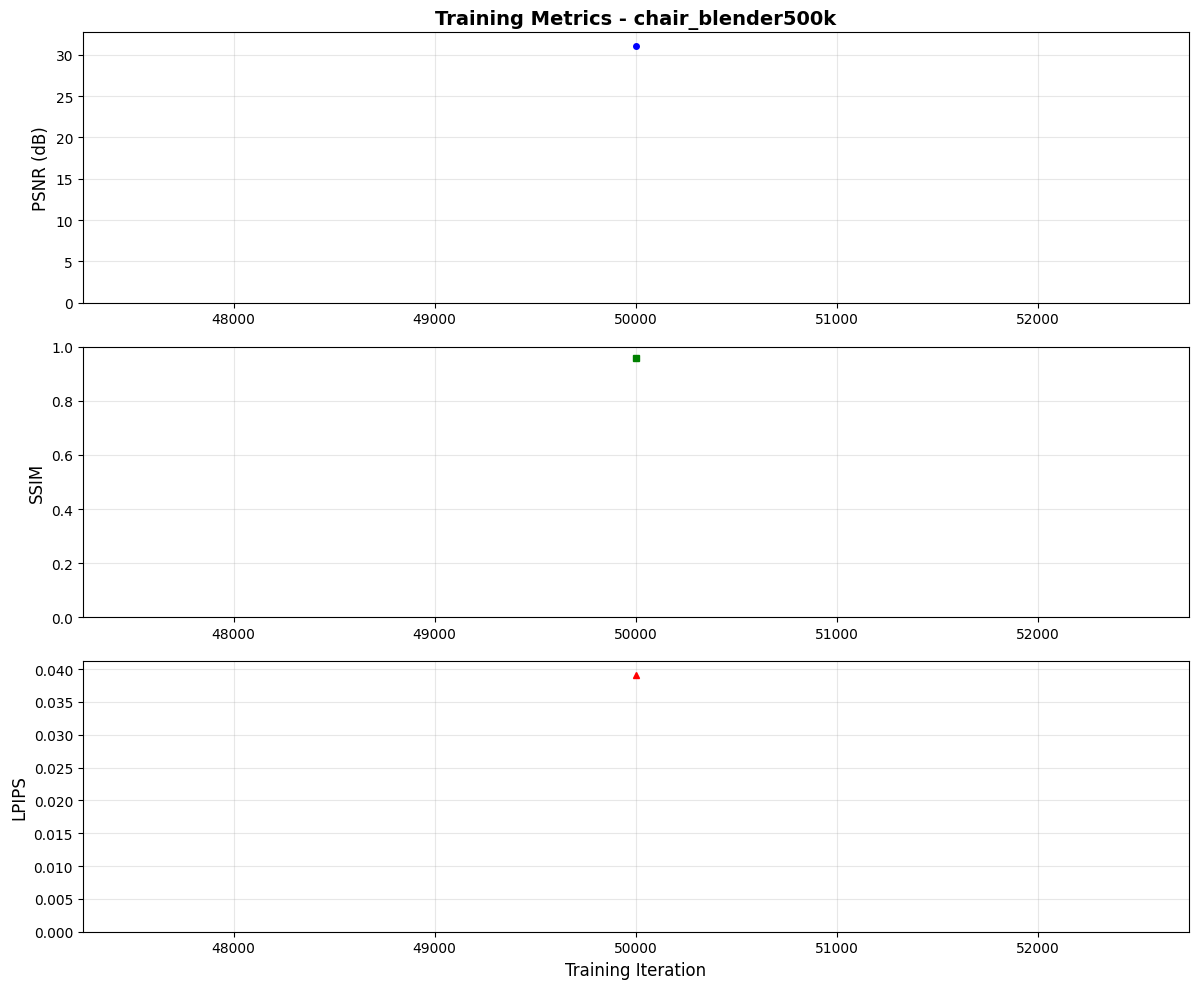

Complete training plot saved to: ./logs/chair_blender500k/complete_training_plot.png


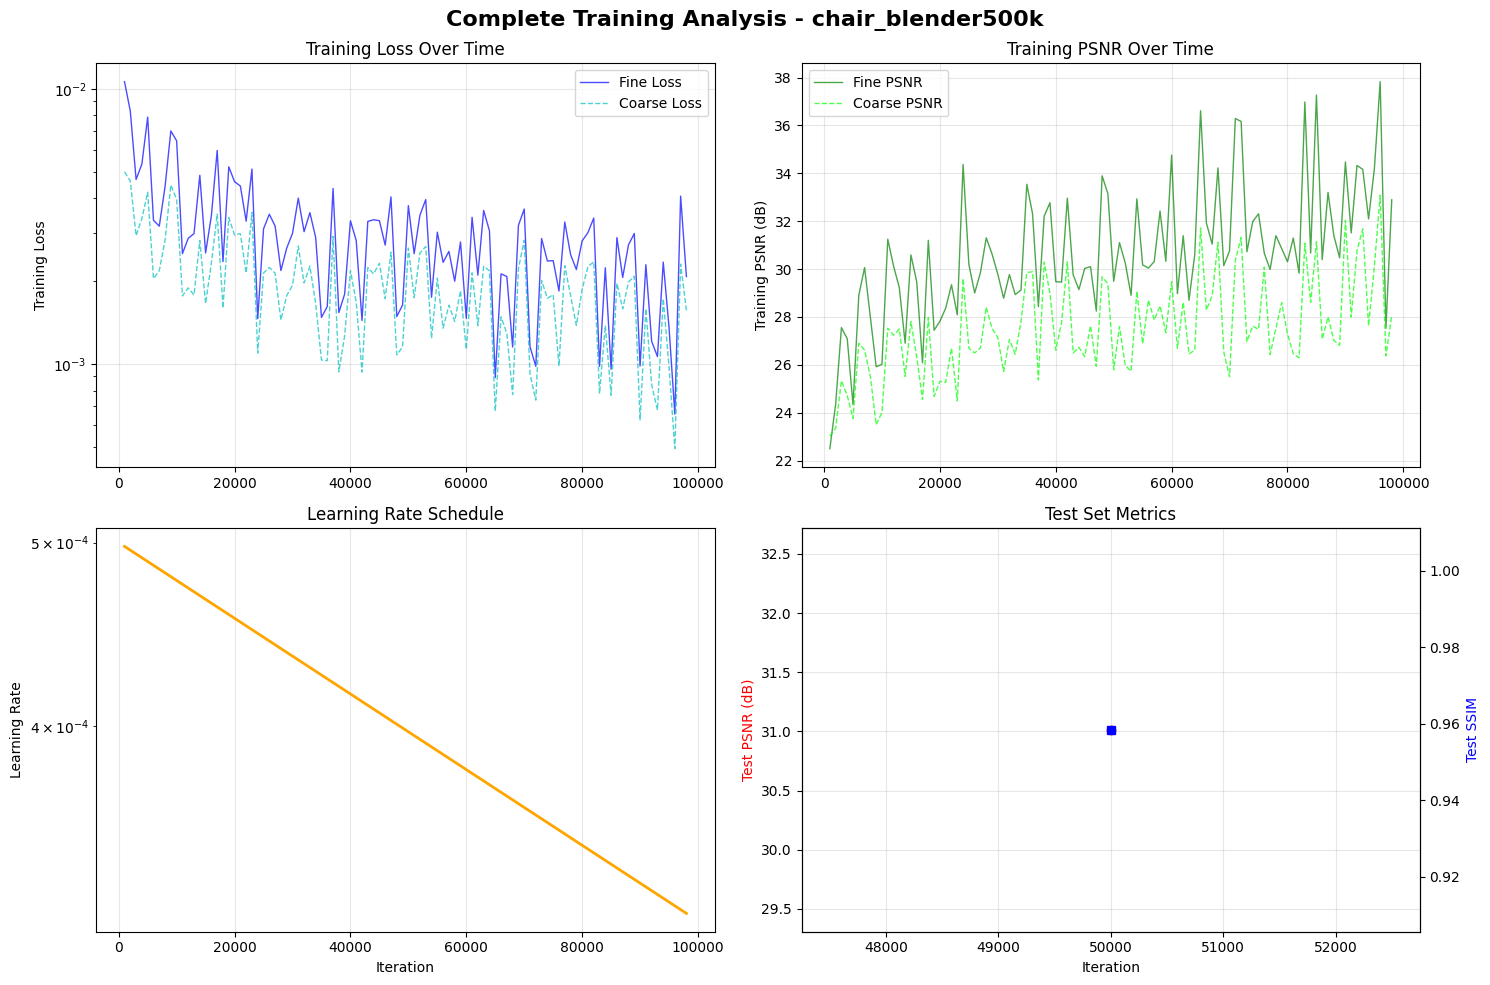

=== TRAINING SUMMARY: chair_blender500k ===
Total iterations: 98,000
Training entries: 98
Latest loss: 0.002076
Latest PSNR: 32.89 dB
Best training PSNR: 37.83 dB
Current learning rate: 3.18e-04

Latest test metrics (iter 50000):
  avg_psnr: 31.0129
  std_psnr: 1.4203
  avg_ssim: 0.9584
  std_ssim: 0.0123
  avg_mse: 0.0008
  std_mse: 0.0002
  avg_lpips: 0.0390
  std_lpips: 0.0097


,iteration,timestamp,loss,psnr,learning_rate,loss_coarse,psnr_coarse
0,1000,2025-09-01 23:54:16,0.010610,22.500252,0.000498,0.004987,23.021698
1,2000,2025-09-01 23:56:03,0.008295,24.348797,0.000495,0.004621,23.352785
2,3000,2025-09-01 23:57:49,0.004680,27.555771,0.000493,0.002925,25.339136
3,4000,2025-09-01 23:59:30,0.005324,27.093473,0.000491,0.003371,24.722002
4,5000,2025-09-02 00:01:19,0.007888,24.340590,0.000489,0.004207,23.760529
...,...,...,...,...,...,...,...
93,94000,2025-09-02 02:38:03,0.002343,32.095913,0.000324,0.001725,27.631273
94,95000,2025-09-02 02:39:43,0.001355,34.189793,0.000323,0.000974,30.113907
95,96000,2025-09-02 02:41:29,0.000657,37.826080,0.000321,0.000492,33.082874
96,97000,2025-09-02 02:43:17,0.004071,27.529268,0.000320,0.002304,26.374353


In [ ]:
# Quick view of your current metrics
get_latest_metrics("chair_blender500k")

# Plot test metrics over time  
plot_training_metrics("chair_blender500k")

# Plot detailed training curves
plot_training_curves("chair_blender500k")

# Get training summary
get_training_summary("chair_blender500k")